In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import cm
from pprint import pprint

import statsmodels.api as sm
import seaborn as sns
import feature_processing as fp

from sklearn.cluster import FeatureAgglomeration

%matplotlib inline

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [4]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC

In [5]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

# Import Data

In [6]:
data = pd.read_csv('./data/trainset_digitized.csv')
target = data.iloc[:, -1]

In [7]:
feature_space = pd.read_csv('./data/F001.csv')

In [8]:
X = np.array(feature_space)
y = np.array(target)

print('X:', X.shape)
print('y:', y.shape)

X: (595212, 127)
y: (595212,)


# Create Datasets with varying number of clusters

In [10]:
%%time
nums_clusters = [20, 40, 80, 100]
reduced_Xs = []
for i, num_cluster in enumerate(nums_clusters):
    agglo = FeatureAgglomeration(n_clusters=num_cluster)#, linkage='average', affinity='l2')
    agglo.fit(X)
    X_reduced = agglo.transform(X)
    reduced_Xs.append(X_reduced)

CPU times: user 12.4 s, sys: 364 ms, total: 12.7 s
Wall time: 12.8 s


In [18]:
Xs = [X] + reduced_Xs

# Compare XGBoost Performance

 Original 127 Features Gini=0.270+/-0.010, Best=0.288
Number of Clusters= 20 Gini=0.245+/-0.011, Best=0.267
Number of Clusters= 40 Gini=0.262+/-0.011, Best=0.285
Number of Clusters= 80 Gini=0.270+/-0.009, Best=0.293
Number of Clusters=100 Gini=0.273+/-0.011, Best=0.296
CPU times: user 1h 45min 4s, sys: 17 s, total: 1h 45min 21s
Wall time: 14min 29s


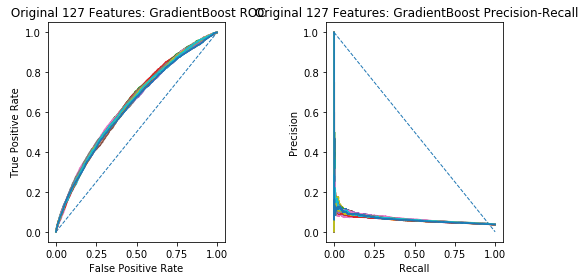

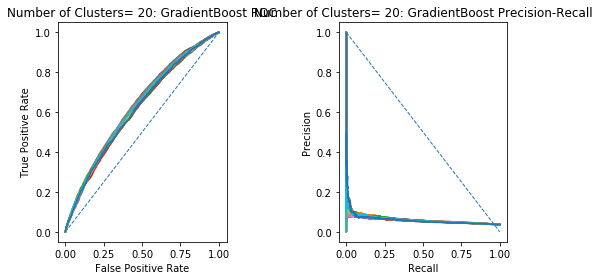

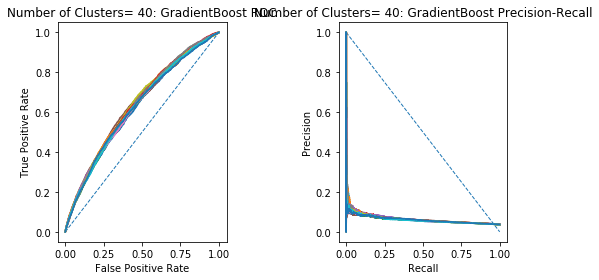

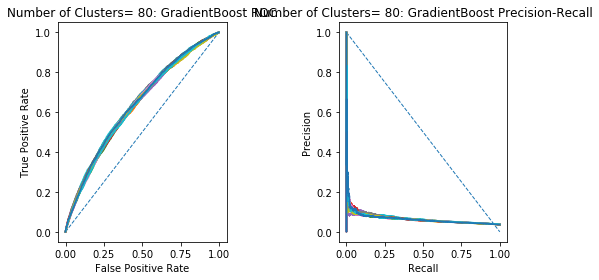

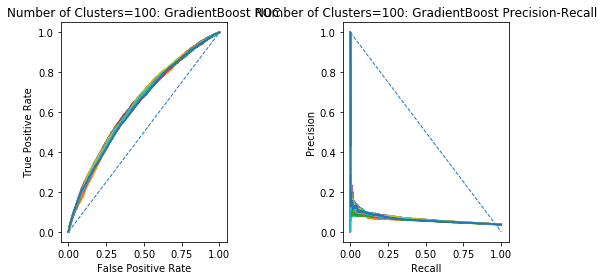

In [22]:
%%time

for X in Xs:
    num_clusters = X.shape[1]
    if num_clusters == 127:
        label = ' Original 127 Features'
    else:
        label = 'Number of Clusters=%3d' % num_clusters

    fig = plt.figure(figsize=(8, 4))
    ax21 = fig.add_subplot(1, 2, 1)
    ax22 = fig.add_subplot(1, 2, 2)

    neutral_line = np.linspace(0, 1, 10)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

    ginis_xgb = []

    for i in range(20):

        rstate = None
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rstate)

        num_class1 = np.sum(y_train)
        num_class1_to_resample = 2 * num_class1
        num_class0_to_resample = int(1 * num_class1_to_resample)

        # First, randomly undersample the majority
        rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
        X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

        # Then use SMOTE to oversample the minority
        smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
        X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

        # GradientBoost
        clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
        clf.fit(X_res, y_res)

        y_pred2 = clf.predict(X_test)
        y_proba2 = clf.predict_proba(X_test)
        ginis_xgb.append(my_gini(y_test, y_proba2))
        report2 = classification_report(y_test, y_pred2, digits=4,
                                       labels=None, target_names=None)

        precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
        fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
        ax21.plot(fpr2, tpr2)
        ax21.set_xlabel('False Positive Rate')
        ax21.set_ylabel('True Positive Rate')
        ax21.set_title('%s: GradientBoost ROC' % label)
        ax22.plot(recall2, precision2)
        ax22.set_xlabel('Recall')
        ax22.set_ylabel('Precision')
        ax22.set_title('%s: GradientBoost Precision-Recall' % label)

    plt.tight_layout()

    print('%s Gini=%.3f+/-%.3f, Best=%.3f' % (label, np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

plt.tight_layout()

## Comment
Hmm... it's hard to tell whether 80 clusters is as good as 100 or without agglomeration. Performance difference is marginally different, though it may matter in the context of LB...Maybe try recursive feature elimination instead.